# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5053070858711924564
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5212703226888664745
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Sat Dec 18 01:08:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    34W / 250W |    375MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'Xception'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 7
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4", "S5", "S6"
T_all_labels = "T0", "T1", "T2", "T3", "T4", "T5", "T6"

#base_path = ''
base_path = 'gdrive/My Drive/Research_7_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_Xception_None S_Xception_imagenet T_Xception_None T_Xception_imagenet


['S_Xception_imagenet',
 'S_Xception_None',
 'T_Xception_imagenet',
 'T_Xception_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2358, 128, 128, 3) (2358, 1)
(786, 128, 128, 3) (786, 1)
(786, 128, 128, 3) (786, 1)

(2598, 128, 128, 3) (2598, 1)
(866, 128, 128, 3) (866, 1)
(866, 128, 128, 3) (866, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2358, 128, 128, 3) (2358, 7)
(786, 128, 128, 3) (786, 7)
(786, 128, 128, 3) (786, 7)

(2598, 128, 128, 3) (2598, 7)
(866, 128, 128, 3) (866, 7)
(866, 128, 128, 3) (866, 7)


## 2-2. Image Check

xTrain_S image Numbers :  2358
xTrain_S image Numbers // 10 :  235
11


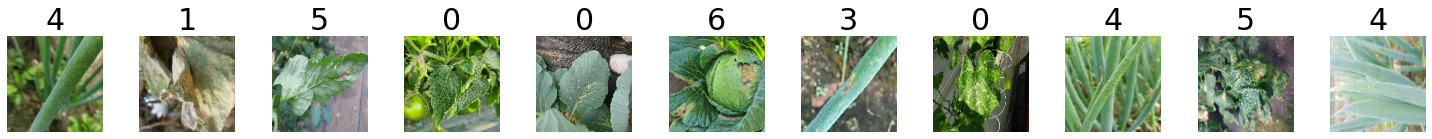

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2598
xTrain_S image Numbers // 10 :  259
11


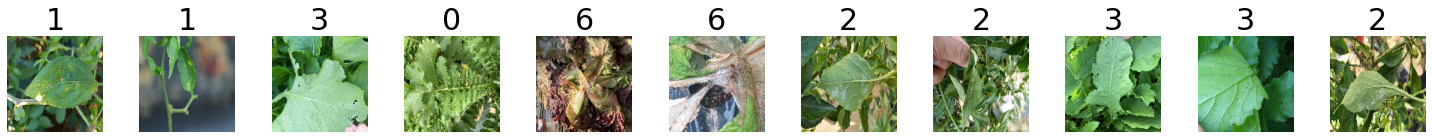

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.Xception (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.Xception (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
37/37 [==============================] - 24s 304ms/step - loss: 1.2624 - accuracy: 0.5776 - val_loss: 1.9404 - val_accuracy: 0.3053
Epoch 2/100
37/37 [==============================] - 9s 250ms/step - loss: 0.8585 - accuracy: 0.7031 - val_loss: 1.9371 - val_accuracy: 0.0865
Epoch 3/100
37/37 [==============================] - 9s 250ms/step - loss: 0.5659 - accuracy: 0.7998 - val_loss: 1.9417 - val_accuracy: 0.1272
Epoch 4/100
37/37 [==============================] - 9s 251ms/step - loss: 0.4916 - accuracy: 0.8202 - val_loss: 1.9503 - val_accuracy: 0.1272
Epoch 5/100
37/37 [==============================] - 9s 250ms/step - loss: 0.3836 - accuracy: 0.8617 - val_loss: 1.9773 - val_accuracy: 0.1272
Epoch 6/100
37/37 [==============================] - 9s 251ms/step - loss: 0.3767 - accuracy: 0.8609 - val_loss: 2.0529 - val_accuracy: 0.1272
Epoch 7/100
37/37 [==============================] - 9s 251ms/step - loss: 0.2983 - accuracy: 0.8910 - val_loss: 2.1475 - val_accuracy: 0.185

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.262393,0.577608,1.940380,0.305344
1,0.858464,0.703138,1.937140,0.086514
2,0.565902,0.799830,1.941654,0.127226
3,0.491632,0.820187,1.950258,0.127226
4,0.383625,0.861747,1.977339,0.127226
...,...,...,...,...
95,0.007005,0.997455,0.907070,0.856234
96,0.036743,0.989398,2.542878,0.698473
97,0.020876,0.993215,1.446235,0.781170
98,0.005338,0.997880,2.719315,0.624682


Minimum validation loss: 0.27561429142951965
Maximum validation accuracy: 0.9427480697631836


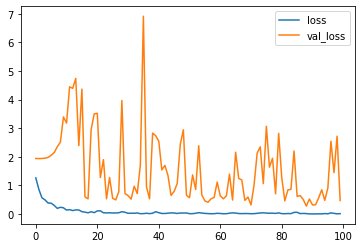

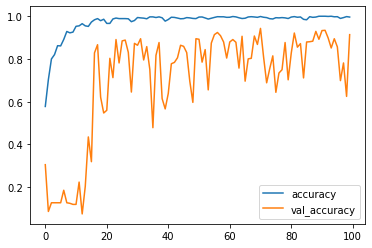

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
25/25 [==============================] - 1s 30ms/step - loss: 0.5575 - accuracy: 0.8919
test loss, test acc: [0.5575135946273804, 0.8918575048446655]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

25/25 [==============================] - 1s 26ms/step


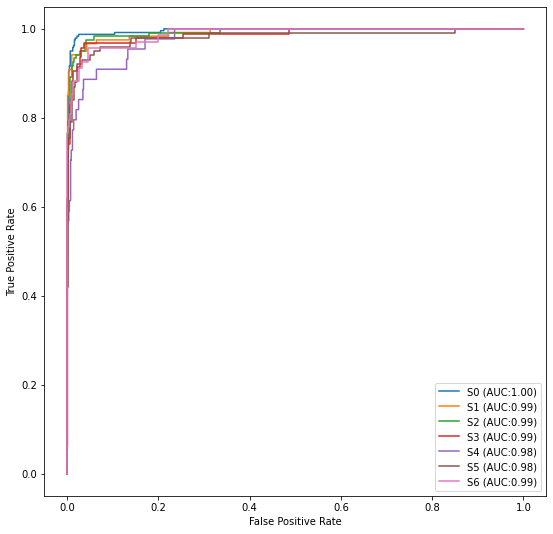

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

83697664/83683744 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
37/37 [==============================] - 14s 284ms/step - loss: 0.6998 - accuracy: 0.7680 - val_loss: 6.5198 - val_accuracy: 0.4987
Epoch 2/100
37/37 [==============================] - 9s 253ms/step - loss: 0.1519 - accuracy: 0.9508 - val_loss: 0.9309 - val_accuracy: 0.8511
Epoch 3/100
37/37 [==============================] - 9s 250ms/step - loss: 0.1240 - accuracy: 0.9652 - val_loss: 1.1539 - val_accuracy: 0.8142
Epoch 4/100
37/37 [==============================] - 9s 250ms/step - loss: 0.0687 - accuracy: 0.9822 - val_loss: 3.8966 - val_accuracy: 0.5941
Epoch 5/100
37/37 [==============================] - 9s 254ms/step - loss: 0.0622 - accuracy: 0.9809 - val_loss: 0.1896 - val_accuracy: 0.9453
Epoch 6/100
37/37 [==============================] - 9s 251ms/step - loss: 0.0629 - accuracy: 0.9826 - val_loss: 0.7174 - val_accuracy: 0.8473
Epoch 7/100
37/37 [==============================] - 9s 251ms/step - loss: 0.0830 - accuracy: 0.9754 - val_loss: 0.5153 - val_accuracy: 0.865

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.699812,0.768024,6.519757,0.498728
1,0.151863,0.950806,0.930927,0.851145
2,0.123951,0.965225,1.153861,0.814249
3,0.068741,0.982188,3.896560,0.594148
4,0.062223,0.980916,0.189577,0.945293
...,...,...,...,...
56,0.015756,0.997031,0.185680,0.966921
57,0.009702,0.996607,0.327930,0.951654
58,0.011665,0.997455,0.335310,0.912214
59,0.010482,0.997455,0.838072,0.862595


Minimum validation loss: 0.03122066706418991
Maximum validation accuracy: 0.9923664331436157


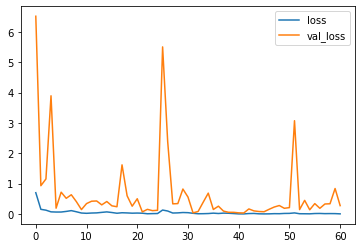

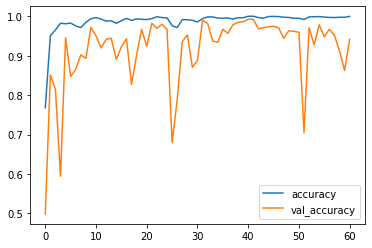

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
25/25 [==============================] - 1s 29ms/step - loss: 0.0723 - accuracy: 0.9796
test loss, test acc: [0.07228492200374603, 0.9796437621116638]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

25/25 [==============================] - 1s 27ms/step


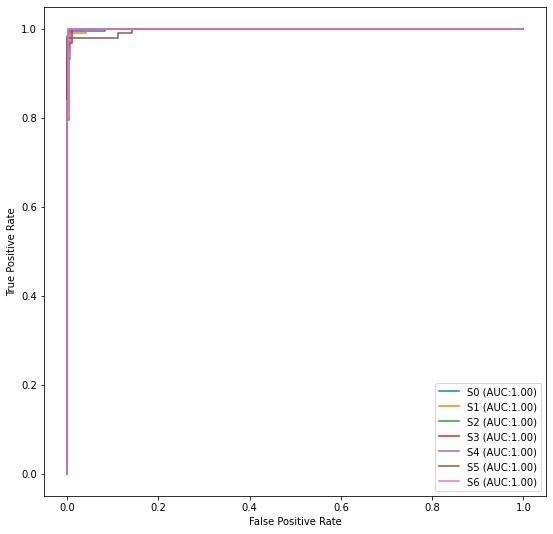

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
41/41 [==============================] - 16s 291ms/step - loss: 1.2928 - accuracy: 0.5196 - val_loss: 1.9272 - val_accuracy: 0.1848
Epoch 2/100
41/41 [==============================] - 10s 251ms/step - loss: 0.8645 - accuracy: 0.6882 - val_loss: 1.9039 - val_accuracy: 0.2714
Epoch 3/100
41/41 [==============================] - 10s 249ms/step - loss: 0.6553 - accuracy: 0.7587 - val_loss: 1.8799 - val_accuracy: 0.1848
Epoch 4/100
41/41 [==============================] - 10s 252ms/step - loss: 0.5338 - accuracy: 0.8029 - val_loss: 1.8772 - val_accuracy: 0.2771
Epoch 5/100
41/41 [==============================] - 10s 249ms/step - loss: 0.5018 - accuracy: 0.8191 - val_loss: 1.9686 - val_accuracy: 0.1155
Epoch 6/100
41/41 [==============================] - 10s 250ms/step - loss: 0.3850 - accuracy: 0.8476 - val_loss: 1.9723 - val_accuracy: 0.1848
Epoch 7/100
41/41 [==============================] - 10s 250ms/step - loss: 0.3572 - accuracy: 0.8572 - val_loss: 1.9523 - val_accuracy:

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.292789,0.519630,1.927211,0.184758
1,0.864511,0.688222,1.903854,0.271363
2,0.655324,0.758660,1.879949,0.184758
3,0.533780,0.802925,1.877196,0.277136
4,0.501751,0.819092,1.968605,0.115473
...,...,...,...,...
91,0.037540,0.989222,1.361622,0.773672
92,0.028617,0.989607,1.552827,0.765589
93,0.015065,0.994611,0.962335,0.806005
94,0.009267,0.997691,0.796243,0.863741


Minimum validation loss: 0.6568272113800049
Maximum validation accuracy: 0.8741339445114136


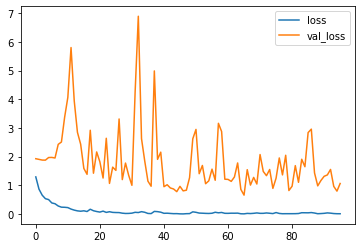

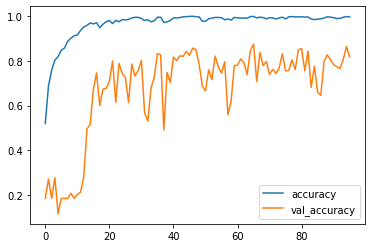

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
28/28 [==============================] - 1s 32ms/step - loss: 0.6486 - accuracy: 0.8557
test loss, test acc: [0.6486191749572754, 0.8556581735610962]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

28/28 [==============================] - 2s 26ms/step


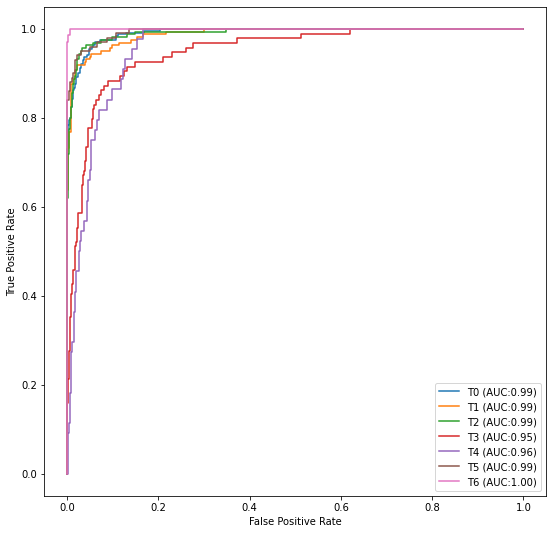

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
41/41 [==============================] - 15s 273ms/step - loss: 0.6913 - accuracy: 0.7602 - val_loss: 4.4940 - val_accuracy: 0.5231
Epoch 2/100
41/41 [==============================] - 10s 251ms/step - loss: 0.2172 - accuracy: 0.9230 - val_loss: 4.7257 - val_accuracy: 0.6605
Epoch 3/100
41/41 [==============================] - 10s 251ms/step - loss: 0.1354 - accuracy: 0.9515 - val_loss: 1.4852 - val_accuracy: 0.6778
Epoch 4/100
41/41 [==============================] - 10s 251ms/step - loss: 0.1066 - accuracy: 0.9657 - val_loss: 1.0717 - val_accuracy: 0.7610
Epoch 5/100
41/41 [==============================] - 10s 252ms/step - loss: 0.1179 - accuracy: 0.9677 - val_loss: 1.1782 - val_accuracy: 0.8025
Epoch 6/100
41/41 [==============================] - 10s 252ms/step - loss: 0.1307 - accuracy: 0.9623 - val_loss: 0.8438 - val_accuracy: 0.8141
Epoch 7/100
41/41 [==============================] - 10s 249ms/step - loss: 0.0801 - accuracy: 0.9777 - val_loss: 3.1353 - val_accuracy:

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.691291,0.760200,4.493998,0.523095
1,0.217189,0.923018,4.725745,0.660508
2,0.135435,0.951501,1.485202,0.677829
3,0.106615,0.965743,1.071739,0.760970
4,0.117866,0.967667,1.178209,0.802540
5,0.130704,0.962279,0.843838,0.814088
6,0.080089,0.977675,3.135282,0.699769
7,0.100155,0.969977,1.089321,0.773672
8,0.054317,0.984604,0.418958,0.922633
9,0.062788,0.983064,1.625271,0.889145


Minimum validation loss: 0.29246750473976135
Maximum validation accuracy: 0.9538106322288513


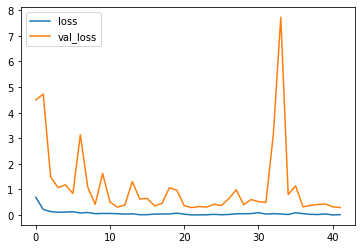

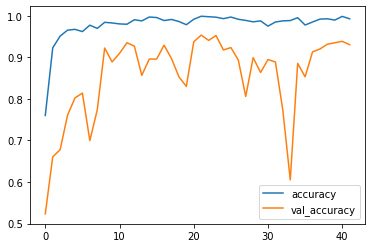

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
28/28 [==============================] - 1s 29ms/step - loss: 0.3526 - accuracy: 0.9330
test loss, test acc: [0.3525541126728058, 0.9330254197120667]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

28/28 [==============================] - 1s 26ms/step


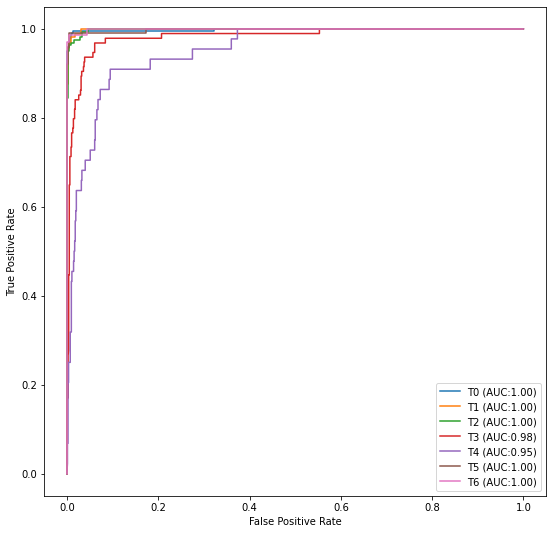

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_Xception_None
test loss, test acc: [0.5575135946273804, 0.8918575048446655]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_Xception_imagenet
test loss, test acc: [0.07228492200374603, 0.9796437621116638]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_Xception_None
test loss, test acc: [0.6486191749572754, 0.8556581735610962]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_Xception_imagenet
test loss, test acc: [0.3525541126728058, 0.9330254197120667]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_Xception_None →→→ Target Test
28/28 [==============================] - 1s 29ms/step - loss: 8.6177 - accuracy: 0.1397
test loss, test acc: [8.617683410644531, 0.13972286880016327]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_Xception_imagenet →→→ Target Test
28/28 [==============================] - 1s 29ms/step - loss: 4.6512 - accuracy: 0.2102
test loss, test acc: [4.6512131690979, 0.21016165614128113]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_Xception_None →→→ Source Test
25/25 [==============================] - 1s 29ms/step - loss: 7.5094 - accuracy: 0.2545
test loss, test acc: [7.509363651275635, 0.2544529139995575]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_Xception_imagenet →→→ Source Test
25/25 [==============================] - 1s 29ms/step - loss: 4.4683 - accuracy: 0.2061
test loss, test acc: [4.468269348144531, 0.20610687136650085]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
